In [2]:
!unzip model.zip

Archive:  model.zip
  inflating: model.pt                


In [9]:
!pip install -r requirements.txt >> none

In [121]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 4.6 MB/s eta 0:00:0000:0100:01m


In [10]:
# import sys
import os
import gc
import warnings
import random
from copy import deepcopy
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from madgrad import MADGRAD, MirrorMADGRAD
from torch.optim import AdamW
from sklearn.metrics import f1_score
from transformers import (
    get_constant_schedule,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)

from sklearn.model_selection import StratifiedKFold,KFold
from tqdm import tqdm
import cv2

import albumentations as A
warnings.filterwarnings("ignore")
tqdm.pandas()

In [11]:
PROJECT_DIR = "/content/drive/MyDrive/ml/Контесты/rucode_6/a"

# EDA

In [12]:
classes = ['Red', 'Green', 'Violet', 'White', 'Yellow', 'Brown', 'Black', 'Blue', 'Cyan', 'Grey', 'Orange']
counts = []
for class_name in classes:
    counts.append(len(os.listdir(f"./data_ext/train/{class_name}")))

<BarContainer object of 11 artists>

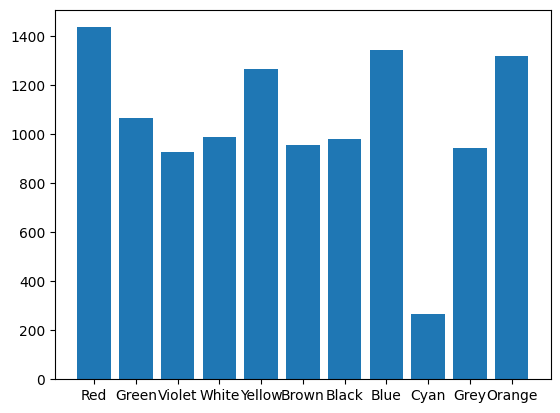

In [13]:
plt.bar(classes, counts)

# Losses

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, weight, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


class ArcFaceLoss(nn.Module):
    def __init__(self, s=45.0, m=0.1, crit="bce", weight=None, reduction="mean",
                 focal_loss_gamma=0, class_weights_norm="batch"):
        super().__init__()

        self.weight = weight
        self.reduction = reduction
        self.class_weights_norm = class_weights_norm
        
        if crit == "focal":
            self.crit = FocalLoss(gamma=focal_loss_gamma)
        elif crit == "bce":
            self.crit = nn.CrossEntropyLoss(reduction="none")   

        if s is None:
            self.s = torch.nn.Parameter(torch.tensor([45.], requires_grad=True, device='cuda'))
        else:
            self.s = s

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, logits, labels):

        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        labels2 = torch.zeros_like(cosine)
        labels2.scatter_(1, labels.view(-1, 1).long(), 1)
        labels2 *= (1 - 0.1)
        labels2 += 0.005
        output = (labels2 * phi) + ((1.0 - labels2) * cosine)

        s = self.s

        output = output * s
        loss = self.crit(output, labels)

        if self.weight is not None:
            w = self.weight[labels].to(logits.device)

            loss = loss * w
            if self.class_weights_norm == "batch":
                loss = loss.sum() / w.sum()
            if self.class_weights_norm == "global":
                loss = loss.mean()
            else:
                loss = loss.mean()
            
            return loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

# Modules

In [18]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine

# Model

In [19]:
class ResNet(nn.Module):
    def __init__(self, backbone, output_dim):
        super().__init__()
        self.backbone = backbone
        del backbone.fc
        self.backbone.dropout = nn.Dropout(p=0.1)
        self.backbone.fc = torch.nn.Linear(in_features=2048, out_features=output_dim, bias=True)
        
    def forward(self, image):
        out = self.backbone(image)
#         out = self.out(x)
        return out

# Loops

In [113]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device, n_accumulated_grads=0):
    model.to(device)
    model.train()
    total_train_loss = 0

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0
    steps_to_accumulate_grads = 0
    for batch in tqdm(data_loader):
        image, target = batch
        image = image["pixel_values"][0].to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(image).logits
                
        preds.append(logits.argmax(dim=1))
        targets.append(target)
                
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1 = f1_score(preds.cpu(), targets.cpu(), average='macro')
    
    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Accuracy": acc.item(),
        "Train F1": f1.item()
    }
    
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        image, target = batch
        image = image["pixel_values"][0].to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(image).logits
            preds.append(logits.argmax(dim=1))
            targets.append(target)
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1 = f1_score(preds.cpu(), targets.cpu(), average='macro')
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Accuracy": acc.item(),
        "Eval F1": f1.item()
    }
    
    return metrics

In [95]:
def save_model(model, path):
    torch.save(model, path+'/model.pt')

In [185]:
def cross_validation(project_name,
                     model, 
                     dataset, 
                     loss_function, 
                     strat_array=None,
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle: bool=True, 
                     n_folds: int=4, 
                     epochs: int=5, 
                     lr: float=1e-6,
                     start_fold: int=0, 
                     batch_size: int=32,
                     iters_to_accumulate=None,
                     n_accumulated_grads: int = 0):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    if strat_array:
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else: 
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            for p in model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
                else:
                    nn.init.normal_(p)
            
            '''run = wandb.init(
                name=f"fold_{fold}",
                project=f"{project_name}_fold_{fold}",
                config={ 
                         "random_state": random_state, 
                         "shuffle": shuffle,
                         "epochs": epochs, 
                         "learning_rate": lr,
                         "batch_size": batch_size,
                         "iters_to_accumulate": iters_to_accumulate
                        }
            )'''

            optimizer = MADGRAD(
            model.parameters(),
            lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
        )

            train_subsampler = torch.utils.data.Subset(dataset,  train_ids)
            train_loader = torch.utils.data.DataLoader(
                          train_subsampler, 
                          batch_size=batch_size,
                          shuffle=shuffle)

            eval_subsampler = torch.utils.data.Subset(dataset,  eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                          eval_subsampler,
                          batch_size=batch_size,
                          shuffle=shuffle)
            
            total_steps = len(train_loader) * epochs 

            scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

            mrrs = []

            for epoch_i in range(0, epochs):
                train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
                eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
                
                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)
                
                #run.log(train_metrics)
                #run.log(eval_metrics)
                            
            #run.finish()


def single_model(model, 
                     dataset, 
                     loss_function, 
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle=True,
                     epochs: int=15, 
                     lr: float=1e-6,
                     batch_size: int=32,
                     start_epoch=0
                     ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    model.to(device)

    optimizer = MADGRAD(
        model.parameters(),
        lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    )
    
    fold_path = f'vit'
    if not os.path.exists(fold_path):
        os.mkdir(fold_path)
        
    data_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=shuffle
    )
    
    total_steps = len(data_loader) * epochs 

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        if epoch_i >= start_epoch:
            train_metrics = train_epoch(model, data_loader, loss_function, optimizer, scheduler, device)
            epoch_path = fold_path+f'/epoch_{epoch_i + 9}'
            if not os.path.exists(epoch_path):
                os.mkdir(epoch_path)
            save_model(model, epoch_path)
            print("EPOCH", epoch_i)
            print(train_metrics)
            # eval_epoch(fold_model, eval_loader, loss_function, device)

In [115]:
def analyze(model, dataset, device):
    score = np.zeros(11)
    
    model.eval()
    model.to(device)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = True)
    for image,target in tqdm(data_loader):
        image = image.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            preds = model(image)
            if preds.argmax(dim = 1).item() == target.item():
                score[preds.argmax(dim = 1).item()] += 1
    
    #for i,fold in enumerate(os.listdir('data_ext/train')):
        #score[i] /= len(os.listdir(f'data_ext/train/{fold}'))
    return score

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
def build_confusion_matrix(model, dataset, device):
    model.eval()
    model.to(device)
    
    preds = []
    targets = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)
    
    for image, target in tqdm(data_loader):
        image = image.to(device)
        taget = target.to(device)
        targets.append(target.item())
        
        with torch.no_grad():
            logits = model(image)
            preds.append(logits.argmax(dim = 1).item())
    
    conf_mat = confusion_matrix(targets, preds, labels = [x for x in range(11)])
    return conf_mat

# Cross Validation

In [26]:
!nvidia-smi

Sun Nov 20 23:49:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Graphics...  On   | 00000000:05:00.0  On |                  Off |
|  0%   42C    P8    34W / 450W |   5761MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [119]:
strat_array = []
target_class = 0
for folder in tqdm(os.listdir('data_ext/train')):
    for _ in range(len(os.listdir('data_ext/train'+f'/{folder}'))):
        strat_array.append(target_class)
    print(folder)
    target_class += 1

100%|██████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1599.66it/s]

Brown
Orange
Violet
Black
Yellow
Grey
Red
White
Cyan
Blue
Green


In [28]:
from sklearn.utils.class_weight import compute_class_weight

In [86]:
n = len(strat_array)
weights = []
classes = np.arange(11)
correct_weights = compute_class_weight(
                                        class_weight = 'balanced',
                                        classes = classes,
                                        y = np.array(strat_array) )

In [30]:
correct_weights

array([1.09147905, 0.79192226, 1.12558777, 1.06586271, 0.8263809 ,
       1.10651002, 0.72790624, 1.05937673, 3.91215526, 0.77719156,
       0.97987378])

In [68]:
# import torch
# model_weights = torch.load('model.pt')
# model = torchvision.models.resnet50(weights=model_weights)
# model.fc = nn.Linear(2048, 11)
# model

In [133]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("therealcyberlord/stanford-car-vit-patch16")
model = AutoModelForImageClassification.from_pretrained("therealcyberlord/stanford-car-vit-patch16")
model.classifier = nn.Linear(768, 11)

In [126]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [71]:
loss_function=FocalLoss(weight=torch.tensor(correct_weights).float())

In [72]:
import gc
torch.cuda.empty_cache()
gc.collect()

717

In [103]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms=torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomHorizontalFlip(p=0.6),
    torchvision.transforms.RandomVerticalFlip(p=0.6),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(224,224)),
#     torchvision.transforms.Lambda(lambda a: a / 255),
    torchvision.transforms.Lambda(lambda a: extractor(a)),

    
#     torchvision.transforms.Normalize(mean, std)
])
train_dataset = torchvision.datasets.ImageFolder(f"./data_ext/train", transform=transforms)
train_dataset.classes

['Black',
 'Blue',
 'Brown',
 'Cyan',
 'Green',
 'Grey',
 'Orange',
 'Red',
 'Violet',
 'White',
 'Yellow']

In [128]:
cross_validation(project_name="car_classification",
                     model=model, 
                     dataset=train_dataset,
                     strat_array=strat_array,
                     loss_function=loss_function, 
                     device=torch.device("cuda"),
                     random_state=69, 
                     n_folds=4, 
                     epochs=60, 
                     lr=1e-5,
                     start_fold=0, 
                     batch_size=16)

FOLD 0
--------------------------------


100%|██████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.94it/s]


EPOCH: 0
{'Train Loss': 1.9600689103740487, 'Train Accuracy': 0.2808401882648468, 'Train F1': 0.2435291673441788}
{'Eval Loss': 1.2757467092739212, 'Eval Accuracy': 0.5040028095245361, 'Eval F1': 0.3991138084929604}


 70%|███████████████████████████████████████████▏                  | 375/539 [00:44<00:19,  8.38it/s]


KeyboardInterrupt: 

In [134]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("therealcyberlord/stanford-car-vit-patch16")
model = AutoModelForImageClassification.from_pretrained("therealcyberlord/stanford-car-vit-patch16")
model.classifier = nn.Linear(768, 11)

In [186]:
model = torch.load("vit/epoch_9/model.pt")

In [187]:
single_model(model = model, 
             dataset = train_dataset, 
             loss_function = loss_function, 
             device = torch.device("cuda"),
             random_state = 69, 
             shuffle = True,
             epochs = 15, 
             lr = 1e-5,
             batch_size = 16)

100%|██████████████████████████████████████████████████████████████| 719/719 [01:24<00:00,  8.47it/s]


EPOCH 0
{'Train Loss': 0.034411304865750274, 'Train Accuracy': 0.987641453742981, 'Train F1': 0.9878719419248447}


100%|██████████████████████████████████████████████████████████████| 719/719 [01:24<00:00,  8.55it/s]


EPOCH 1
{'Train Loss': 0.021765308085764982, 'Train Accuracy': 0.9916449189186096, 'Train F1': 0.9919398162485961}


100%|██████████████████████████████████████████████████████████████| 719/719 [01:24<00:00,  8.54it/s]


EPOCH 2
{'Train Loss': 0.024446832974720365, 'Train Accuracy': 0.9915578961372375, 'Train F1': 0.9920070136956093}


100%|██████████████████████████████████████████████████████████████| 719/719 [01:25<00:00,  8.43it/s]


EPOCH 3
{'Train Loss': 0.01959475742733149, 'Train Accuracy': 0.9944299459457397, 'Train F1': 0.9951168999185307}


100%|██████████████████████████████████████████████████████████████| 719/719 [01:27<00:00,  8.25it/s]


EPOCH 4
{'Train Loss': 0.015836114311266844, 'Train Accuracy': 0.9943429231643677, 'Train F1': 0.9948136380550111}


 24%|██████████████▋                                               | 170/719 [00:20<01:05,  8.42it/s]


KeyboardInterrupt: 

In [188]:
from PIL import Image

In [189]:
model = torch.load("vit/epoch_12/model.pt")

In [190]:
test_transforms=torchvision.transforms.Compose([
#     torchvision.transforms.RandomRotation(45),
#     torchvision.transforms.RandomHorizontalFlip(p=0.6),
#     torchvision.transforms.RandomVerticalFlip(p=0.6),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(224,224)),
#     torchvision.transforms.Lambda(lambda a: a / 255),
    torchvision.transforms.Lambda(lambda a: extractor(a)),

    
#     torchvision.transforms.Normalize(mean, std)
])

In [191]:
def predict(model, device, root=f"./data/public_test/", transform=transforms):
    model.eval()
    model.to(device)
    
    preds = []
    
    img_files = sorted(os.listdir(root), key=lambda x: int(x.split(".")[0]))
    for img_file in tqdm(img_files):
        img_rgb = Image.open(root + img_file)
        image = test_transforms(img_rgb)
        image = torch.tensor(image["pixel_values"][0]).unsqueeze(dim=0).to(device)

        with torch.no_grad():
            pred = model(image).logits.argmax(dim=1).cpu().item()
            preds.append(pred)
            
    return pd.Series(preds)

In [192]:
preds = predict(model, device=torch.device("cuda"), root=f"data_ext/public_test/", transform=test_transforms)

100%|███████████████████████████████████████████████████████████| 1436/1436 [00:09<00:00, 156.44it/s]


In [193]:
preds = preds.apply(lambda x: train_dataset.classes[x])

In [194]:
preds.to_csv("vit_submission_2.csv", index=False)

In [109]:
anal = analyze(model = model, dataset=train_dataset, device = 'cuda')

100%|██████████| 11490/11490 [01:33<00:00, 122.48it/s]


In [110]:
classes = train_dataset.classes
counts = []
for class_name in classes:
    counts.append(len(os.listdir(f"./data_ext/train/{class_name}")))

In [111]:
for i in range(11):
    anal[i] /= counts[i]

In [112]:
anal

array([1.        , 1.        , 0.9968652 , 1.        , 0.99906191,
       1.        , 0.9969674 , 0.99721254, 1.        , 1.        ,
       1.        ])

In [126]:
conf_mat = build_confusion_matrix(model = model, dataset = train_dataset, device = 'cuda') 

100%|██████████| 11490/11490 [01:33<00:00, 123.32it/s]


In [127]:
conf_mat

array([[ 979,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0, 1344,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,  952,    0,    0,    1,    0,    0,    0,    0,    3],
       [   0,    0,    0,  267,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1065,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,  944,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1317,    0,    0,    0,    2],
       [   0,    1,    0,    0,    0,    0,    1, 1433,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  928,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  986,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1264]])

In [128]:
train_dataset.classes

['Black',
 'Blue',
 'Brown',
 'Cyan',
 'Green',
 'Grey',
 'Orange',
 'Red',
 'Violet',
 'White',
 'Yellow']

In [132]:
st = 'ABC'
ct = 0
for a in st:
    for b in st:
        for c in st:
            s = a+b+c
            if 'AA' not in s:
                ct += 1

In [133]:
ct

22